# Notebook 1: 基礎 GP 回歸（MAP-II）

本 notebook 示範如何使用 `infodynamics-jax` 進行基礎的高斯過程回歸。

**學習目標：**
- 了解 GP 回歸的基本工作流程
- 學習如何設置帶有誘導點的 GP 模型
- 執行 MAP-II 優化以尋找超參數
- 進行預測並視覺化結果

**主要概念：**
- **MAP-II (Maximum A Posteriori Type-II)**: 在超參數空間中尋找最大後驗估計
- **VFE (Variational Free Energy)**: 用於優化的目標函數
- **稀疏 GP**: 使用誘導點降低計算複雜度從 O(N³) 到 O(NM²+M³)


## 設置環境

In [ ]:
# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

# Configure JAX to use CPU
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Import plotting style
from utils import (
    COLORS, PALETTES, setup_plot_style, get_figure_size,
    plot_with_uncertainty, format_axes
)
setup_plot_style()

# Import library components
from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.kernels.rbf import rbf as rbf_kernel
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective
from infodynamics_jax.gp.predict import predict_typeii

print(f"JAX version: {jax.__version__}")

In [1]:
# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

# Fix import path
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Import plotting style
from utils import (
    COLORS, PALETTES, setup_plot_style, get_figure_size,
    plot_with_uncertainty, format_axes
)
setup_plot_style()

# Import library components
from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.kernels.rbf import rbf as rbf_kernel
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective
from infodynamics_jax.gp.predict import predict_typeii

print(f"JAX version: {jax.__version__}")

Metal device set to: Apple M4
JAX version: 0.8.2


W0000 00:00:1768294968.589963 15496273 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1768294968.617375 15496273 service.cc:145] XLA service 0x1797bf0e0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768294968.617386 15496273 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1768294968.618432 15496273 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1768294968.618441 15496273 mps_client.cc:384] XLA backend will use up to 11452776448 bytes on device 0 for SimpleAllocator.


## 1. 生成數據

In [2]:
key = jax.random.key(42)

# 真實函數
def true_function(x):
    return jnp.sin(2 * jnp.pi * x / 3.0) + 0.3 * x

# 生成訓練數據
N_train = 50
X_train = jnp.linspace(-4, 4, N_train)[:, None]
f_train = true_function(X_train[:, 0])

# 添加噪聲
noise_std = 0.2
key, subkey = jax.random.split(key)
Y_train = f_train + noise_std * jax.random.normal(subkey, (N_train,))

# 生成測試數據
X_test = jnp.linspace(-5, 5, 200)[:, None]
f_test = true_function(X_test[:, 0])

print(f"訓練數據點數: {N_train}")
print(f"測試數據點數: {len(X_test)}")
print(f"真實噪聲標準差: {noise_std}")

訓練數據點數: 50
測試數據點數: 200
真實噪聲標準差: 0.2


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/740344668.py:11: UserWarning: Glyph 36664 (\N{CJK UNIFIED IDEOGRAPH-8F38}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/740344668.py:11: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/740344668.py:11: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/740344668.py:11: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/740344668.py:11: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipyker

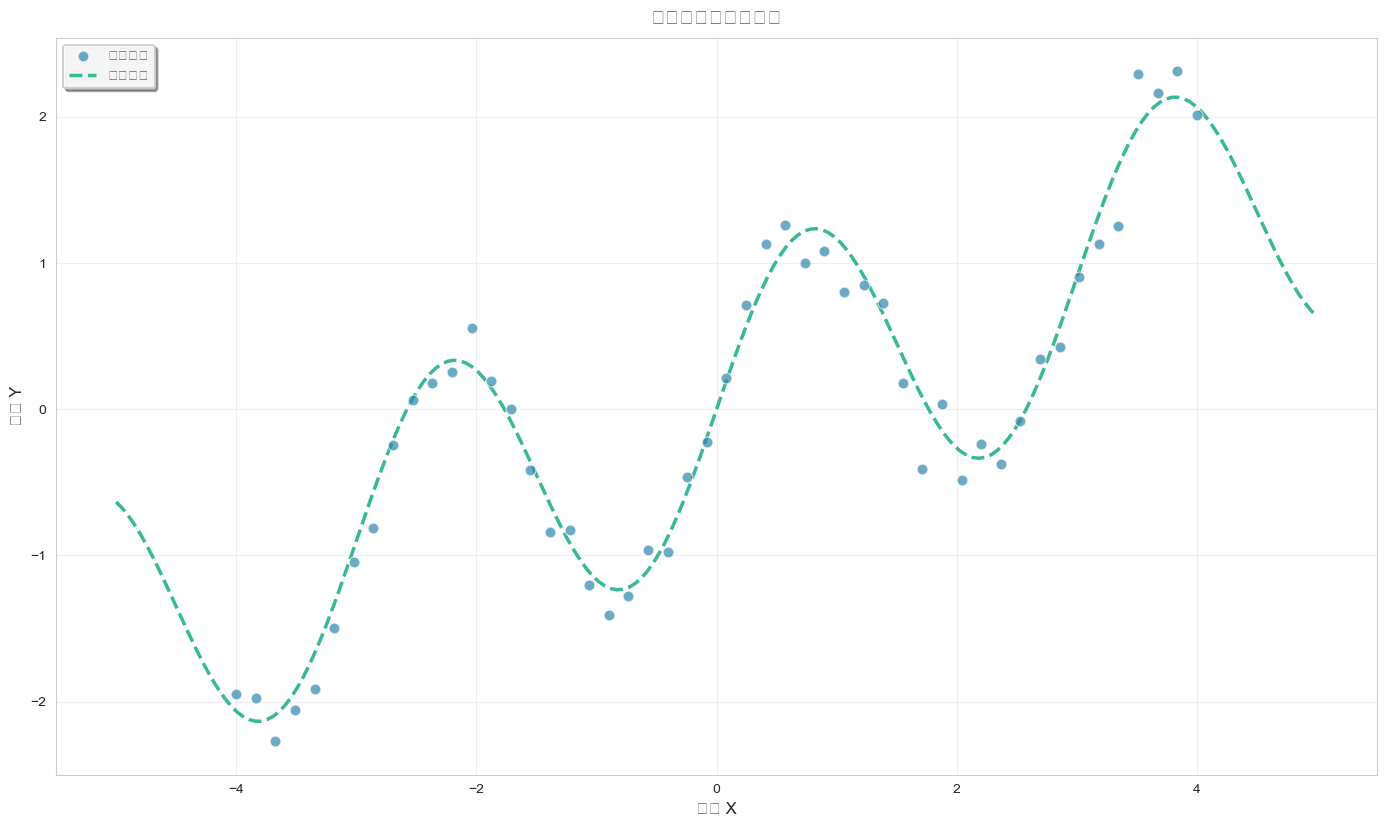

In [3]:
# 視覺化數據
fig, ax = plt.subplots(figsize=get_figure_size('wide', 0.6))

ax.scatter(X_train[:, 0], Y_train, c=COLORS['train'], s=60, alpha=0.7, 
          label='訓練數據', zorder=3, edgecolors='white', linewidths=0.8)
ax.plot(X_test[:, 0], f_test, color=COLORS['true'], linewidth=2.5, 
       label='真實函數', zorder=2, linestyle='--', alpha=0.8)

format_axes(ax, title='訓練數據與真實函數', xlabel='輸入 X', ylabel='輸出 Y', 
           legend=True, legend_loc='upper left')
plt.tight_layout()
plt.show()

## 2. 初始化模型

In [4]:
# 初始化核函數參數
kernel_params = KernelParams(
    lengthscale=jnp.array(1.0),
    variance=jnp.array(1.0)
)

# 設置誘導點（稀疏 GP）
M = 15  # 誘導點數量
Z = jnp.linspace(X_train.min(), X_train.max(), M)[:, None]

# 創建初始 Phi（包含所有結構參數）
phi_init = Phi(
    kernel_params=kernel_params,
    Z=Z,
    likelihood_params={"noise_var": jnp.array(0.1)},
    jitter=1e-5,
)

print(f"誘導點數量: {M}")
print(f"初始長度尺度: {phi_init.kernel_params.lengthscale}")
print(f"初始方差: {phi_init.kernel_params.variance}")
print(f"初始噪聲方差: {phi_init.likelihood_params['noise_var']}")

誘導點數量: 15
初始長度尺度: 1.0
初始方差: 1.0
初始噪聲方差: 0.10000000149011612


## 3. 創建 VFE 目標函數

In [5]:
# VFE (Variational Free Energy) 是 MAP-II 優化的目標函數
# 它結合了負對數似然和正則化項
vfe_objective = make_vfe_objective(kernel_fn=rbf_kernel, residual="fitc")

print("VFE 目標函數已創建")
print("residual='fitc' 表示使用 FITC (Fully Independent Training Conditional) 近似")

VFE 目標函數已創建
residual='fitc' 表示使用 FITC (Fully Independent Training Conditional) 近似


## 4. 執行 MAP-II 優化

In [6]:
# 配置 Type-II 優化器
typeii_cfg = TypeIICFG(
    steps=200,
    lr=1e-2,
    optimizer="adam",
    jit=True,
    constrain_params=True,
    min_noise_var=1e-3,  # 防止噪聲方差過小
)

method = TypeII(cfg=typeii_cfg)

# 運行優化
print("開始 MAP-II 優化...")
result = method.run(
    energy=vfe_objective,
    phi_init=phi_init,
    energy_args=(X_train, Y_train),
)

phi_opt = result.phi
energy_trace = result.energy_trace

print("\n優化完成！")
print(f"最終能量: {energy_trace[-1]:.2f}")
print(f"能量變化: {energy_trace[0] - energy_trace[-1]:.2f}")
print(f"\n優化後的超參數:")
print(f"  長度尺度: {float(phi_opt.kernel_params.lengthscale):.3f}")
print(f"  方差: {float(phi_opt.kernel_params.variance):.3f}")
print(f"  噪聲方差: {float(phi_opt.likelihood_params['noise_var']):.3f}")

開始 MAP-II 優化...

優化完成！
最終能量: 80.50
能量變化: -42.59

優化後的超參數:
  長度尺度: 0.940
  方差: 0.940
  噪聲方差: 0.160


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/3682620565.py:27: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/3682620565.py:27: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/3682620565.py:27: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/3682620565.py:27: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/3682620565.py:27: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/i

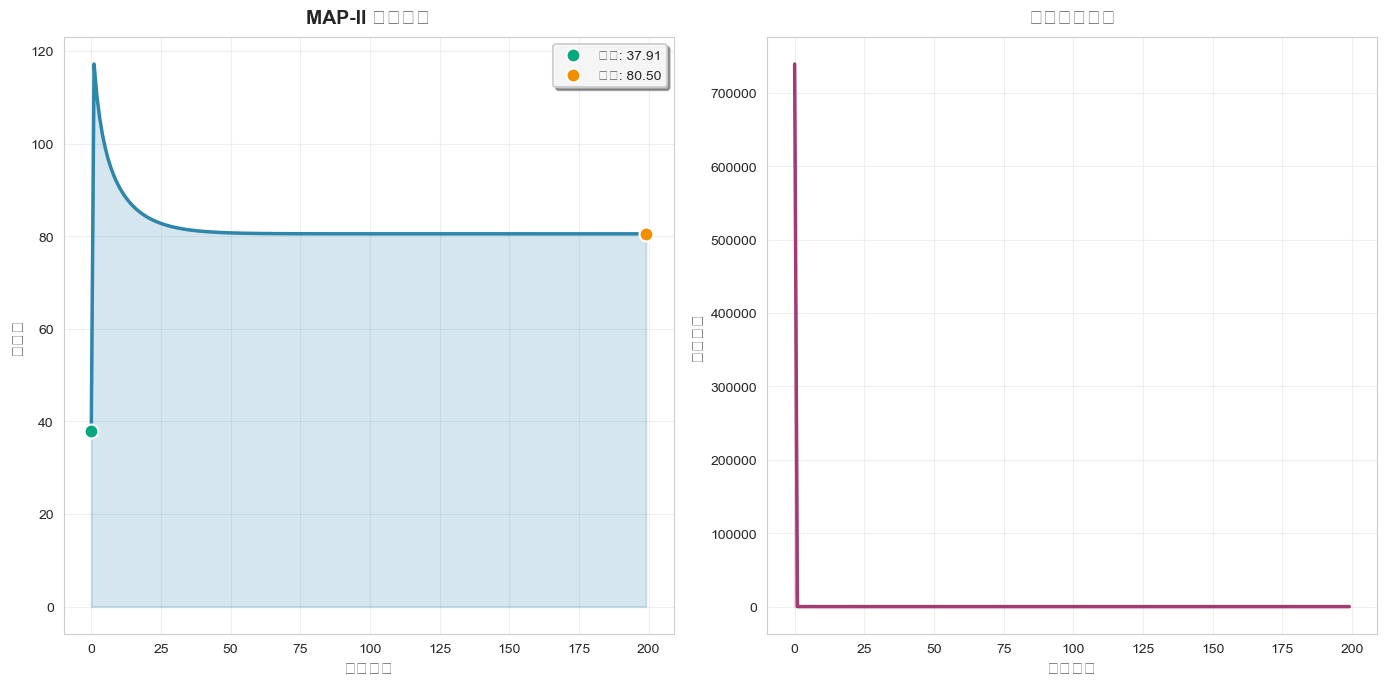

In [7]:
# 視覺化優化過程
fig, axes = plt.subplots(1, 2, figsize=get_figure_size('wide', 0.5))

# 能量軌跡
ax = axes[0]
ax.plot(energy_trace, color=COLORS['primary'], linewidth=2.5, zorder=2)
ax.fill_between(range(len(energy_trace)), energy_trace, 
                alpha=0.2, color=COLORS['primary'], zorder=1)
ax.scatter([0], [energy_trace[0]], color=COLORS['success'], 
          s=100, zorder=4, label=f'初始: {energy_trace[0]:.2f}',
          edgecolors='white', linewidths=1.5)
ax.scatter([len(energy_trace)-1], [energy_trace[-1]], 
          color=COLORS['accent'], s=100, zorder=4, 
          label=f'最終: {energy_trace[-1]:.2f}',
          edgecolors='white', linewidths=1.5)
format_axes(ax, title='MAP-II 優化軌跡', xlabel='迭代次數', 
           ylabel='能量值', legend=True, legend_loc='best')

# 梯度範數軌跡
ax = axes[1]
ax.plot(result.grad_norm_trace, color=COLORS['secondary'], linewidth=2.5, zorder=2)
ax.fill_between(range(len(result.grad_norm_trace)), result.grad_norm_trace, 
                alpha=0.2, color=COLORS['secondary'], zorder=1)
format_axes(ax, title='梯度範數軌跡', xlabel='迭代次數', 
           ylabel='梯度範數', legend=False)

plt.tight_layout()
plt.show()

## 5. 進行預測

In [8]:
# 使用優化後的參數進行預測
mu_test, var_test = predict_typeii(
    phi_opt, X_test, X_train, Y_train, rbf_kernel, residual="fitc"
)

std_test = jnp.sqrt(var_test)

print(f"預測完成！")
print(f"預測均值範圍: [{mu_test.min():.3f}, {mu_test.max():.3f}]")
print(f"預測標準差範圍: [{std_test.min():.3f}, {std_test.max():.3f}]")

預測完成！
預測均值範圍: [-1.937, 1.959]
預測標準差範圍: [0.475, 2.527]


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/2659633762.py:29: UserWarning: Glyph 36664 (\N{CJK UNIFIED IDEOGRAPH-8F38}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/2659633762.py:29: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/2659633762.py:29: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/2659633762.py:29: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_40940/2659633762.py:29: UserWarning: Glyph 27512 (\N{CJK UNIFIED IDEOGRAPH-6B78}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/i

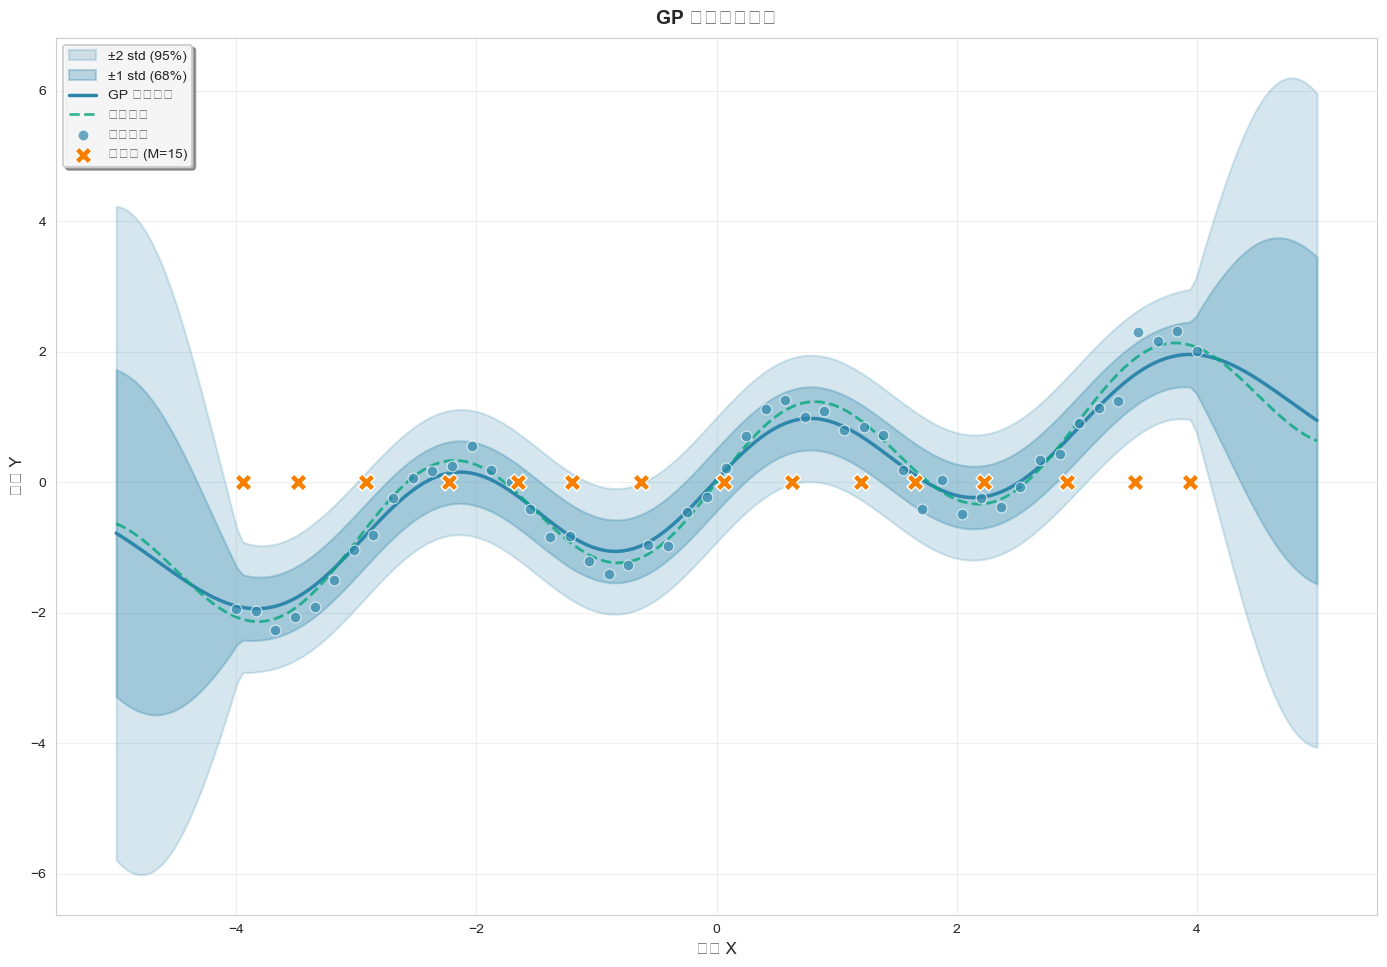

In [9]:
# 視覺化預測結果
fig, ax = plt.subplots(figsize=get_figure_size('wide', 0.7))

# 繪製不確定性區域
ax.fill_between(X_test[:, 0], mu_test - 2 * std_test, mu_test + 2 * std_test,
               color=COLORS['pred'], alpha=0.2, label='±2 std (95%)', zorder=1)
ax.fill_between(X_test[:, 0], mu_test - std_test, mu_test + std_test,
               color=COLORS['pred'], alpha=0.3, label='±1 std (68%)', zorder=2)

# 繪製預測均值
ax.plot(X_test[:, 0], mu_test, color=COLORS['pred'], linewidth=2.5, 
       label='GP 預測均值', zorder=3)

# 繪製真實函數
ax.plot(X_test[:, 0], f_test, color=COLORS['true'], linewidth=2, 
       label='真實函數', zorder=4, linestyle='--', alpha=0.8)

# 繪製訓練數據
ax.scatter(X_train[:, 0], Y_train, c=COLORS['train'], s=60, alpha=0.7, 
          label='訓練數據', zorder=5, edgecolors='white', linewidths=0.8)

# 標記誘導點
ax.scatter(phi_opt.Z[:, 0], jnp.zeros(M), c=COLORS['inducing'], 
          marker='X', s=150, label=f'誘導點 (M={M})', 
          edgecolors='white', linewidths=1, zorder=6)

format_axes(ax, title='GP 回歸預測結果', xlabel='輸入 X', ylabel='輸出 Y', 
           legend=True, legend_loc='upper left')
plt.tight_layout()
plt.show()

## 6. 評估性能

In [10]:
# 計算預測誤差
mse = jnp.mean((f_test - mu_test)**2)
rmse = jnp.sqrt(mse)
mae = jnp.mean(jnp.abs(f_test - mu_test))

print("預測性能指標:")
print(f"  MSE (均方誤差): {mse:.4f}")
print(f"  RMSE (均方根誤差): {rmse:.4f}")
print(f"  MAE (平均絕對誤差): {mae:.4f}")
print(f"\n真實噪聲標準差: {noise_std:.3f}")
print(f"估計噪聲標準差: {jnp.sqrt(phi_opt.likelihood_params['noise_var']):.3f}")

預測性能指標:
  MSE (均方誤差): 0.0265
  RMSE (均方根誤差): 0.1627
  MAE (平均絕對誤差): 0.1410

真實噪聲標準差: 0.200
估計噪聲標準差: 0.400


## 總結

在本 notebook 中，我們學習了：

1. **模型設置**: 使用 `Phi` 結構來組織所有參數（核函數、誘導點、似然函數）
2. **VFE 目標**: 使用 VFE 作為 MAP-II 優化的目標函數
3. **Type-II 優化**: 使用 `TypeII` 優化器尋找最優超參數
4. **預測**: 使用 `predict_typeii` 進行預測並量化不確定性

**關鍵要點：**
- 稀疏 GP 使用誘導點降低計算複雜度
- MAP-II 優化尋找點估計，適合快速推理
- 預測包含不確定性量化，這是 GP 的優勢

**下一步：**
- Notebook 2: 學習如何選擇和比較不同的核函數
- Notebook 3: 處理非共軛似然（分類、計數數據）
- Notebook 4: 使用貝葉斯推斷（SMC）獲得完整的後驗分布
